# Find out on which weekday people bike the most with groupby and aggregate

In [1]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

✅ The installed version of syft==0.8.2b2 matches the requirement >=0.8.2b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-4", port=9084, reset=True)

Starting pandas-test-domain-4 server on 0.0.0.0:9084


Waiting for server to start Done.


# Data owner: upload data

In [4]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

Logged into pandas-test-domain-4 as <info@openmined.org>


## Load data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from pandas._libs.tslibs.timestamps import Timestamp
from syft.service.project.project import Project
from syft.util.util import autocache, PANDAS_DATA

In [6]:
df = pd.read_csv(autocache(f"{PANDAS_DATA}/bikes.csv"), sep=';', encoding='latin1', parse_dates=['Date'], dayfirst=True, index_col='Date')
df[:3]

,Berri 1,Brébeuf (données non disponibles),Côte-Sainte-Catherine,Maisonneuve 1,Maisonneuve 2,du Parc,Pierre-Dupuy,Rachel1,St-Urbain (données non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN


In [7]:
assert len(df) == 310

## Create mock data

In [8]:
import numpy as np
from random import randint

def get_mock_int(i, var=10):
    base = 100 + int(np.cos(i/10) * 50)
    return randint(max(base-var, 1),max(1, base+var))

def get_mock_date(i):
    return str(parse('Jun 1 2005').date() + timedelta(days=i))

# some randomness
r = [(randint(1, 40), randint(1, 40)) for _ in range(7)]

def get_mock_row(i):
    res = [get_mock_int(i+r[j][0], r[j][1]) for j in range(7)]
    # add NaNs in the second and 10th col
    res.insert(1, None), res.insert(9, None)
    return res
    

In [9]:
mock = pd.DataFrame(index=[Timestamp(get_mock_date(i)) for i in range(len(df))],
                    data=[get_mock_row(i) for i in range(len(df))],
                    columns=df.columns)

Upload the data

In [10]:
dataset = sy.Dataset(name="bikes2",
                     asset_list=[sy.Asset(name="bikes", data=df, mock=mock, mock_is_real=False)])
root_domain_client.upload_dataset(dataset)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

Uploading: bikes


<class 'syft.service.response.SyftSuccess'>: Dataset uploaded to 'pandas-test-domain-4'. To see the datasets uploaded by a client on this node, use command `[your_client].datasets`

## create Data scientist

In [11]:
user = root_domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

Logged into pandas-test-domain-4 as <jane@caltech.edu>


## Create user account

# Data Scientist: create syft_function

## Download mock and submit project

### Get mock

In [12]:
ds = guest_domain_client.datasets[0]

In [13]:
asset = ds.assets["bikes"]

In [14]:
asset

syft.service.dataset.dataset.Asset

In [15]:
bikes = asset.mock

### Adding a 'weekday' column to our dataframe

First, we need to load up the data. We've done this before.

<Axes: >

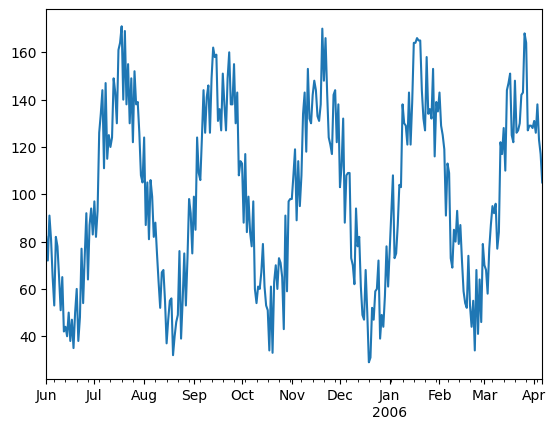

In [16]:
bikes['Berri 1'].plot()

Next up, we're just going to look at the Berri bike path. Berri is a street in Montreal, with a pretty important bike path. I use it mostly on my way to the library now, but I used to take it to work sometimes when I worked in Old Montreal.

So we're going to create a dataframe with just the Berri bikepath in it

In [17]:
berri_bikes = bikes[['Berri 1']].copy()

In [18]:
berri_bikes[:5]

,Berri 1
2005-06-01,82
2005-06-02,72
2005-06-03,91
2005-06-04,81
2005-06-05,65


Next, we need to add a 'weekday' column. Firstly, we can get the weekday from the index. We haven't talked about indexes yet, but the index is what's on the left on the above dataframe, under 'Date'. It's basically all the days of the year.

In [19]:
berri_bikes.index

DatetimeIndex(['2005-06-01', '2005-06-02', '2005-06-03', '2005-06-04',
               '2005-06-05', '2005-06-06', '2005-06-07', '2005-06-08',
               '2005-06-09', '2005-06-10',
               ...
               '2006-03-28', '2006-03-29', '2006-03-30', '2006-03-31',
               '2006-04-01', '2006-04-02', '2006-04-03', '2006-04-04',
               '2006-04-05', '2006-04-06'],
              dtype='datetime64[ns]', length=310, freq=None)

You can see that actually some of the days are missing -- only 310 days of the year are actually there. Who knows why.

Pandas has a bunch of really great time series functionality, so if we wanted to get the day of the month for each row, we could do it like this:

In [20]:
berri_bikes.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            28, 29, 30, 31,  1,  2,  3,  4,  5,  6],
           dtype='int64', length=310)

We actually want the weekday, though:

In [21]:
berri_bikes.index.weekday

Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3],
           dtype='int64', length=310)

These are the days of the week, where 0 is Monday. I found out that 0 was Monday by checking on a calendar.

Now that we know how to get the weekday, we can add it as a column in our dataframe like this:

In [22]:
berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
berri_bikes[:5]

,Berri 1,weekday
2005-06-01,82,2
2005-06-02,72,3
2005-06-03,91,4
2005-06-04,81,5
2005-06-05,65,6


### Adding up the cyclists by weekday

This turns out to be really easy!

Dataframes have a `.groupby()` method that is similar to SQL groupby, if you're familiar with that. I'm not going to explain more about it right now -- if you want to to know more, the [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) is really good.

In this case, `berri_bikes.groupby('weekday').aggregate(sum)` means "Group the rows by weekday and then add up all the values with the same weekday".

In [23]:
weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
weekday_counts

,Berri 1
weekday,
0,4531
1,4509
2,4616
3,4245
4,4402
5,4351
6,4349


It's hard to remember what 0, 1, 2, 3, 4, 5, 6 mean, so we can fix it up and graph it:

In [24]:
# weekday_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# weekday_counts

<Axes: xlabel='weekday'>

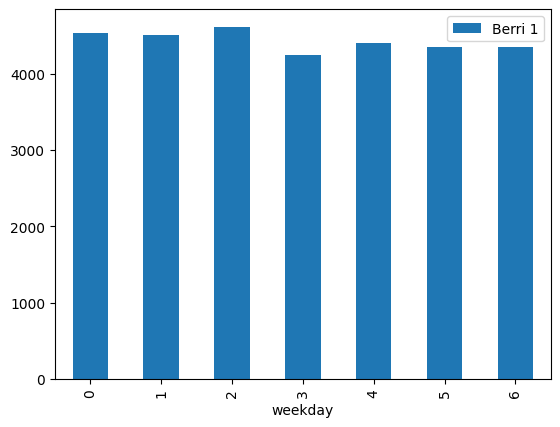

In [25]:
weekday_counts.plot(kind='bar')

So it looks like Montrealers are commuter cyclists -- they bike much more during the week. Neat!

### Putting it together

Now we want to request the full code execution.

Let's put all that together, to prove how easy it is. 6 lines of magical pandas!

If you want to play around, try changing sum to max, numpy.median, or any other function you like.

In [26]:
# Todo, fix indexes in function

In [27]:
@sy.syft_function(input_policy=sy.ExactMatch(bikes=asset.pointer),
                  output_policy=sy.SingleExecutionExactOutput())
def get_bike_hist(bikes):
    berri_bikes = bikes[['Berri 1']].copy()
    berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
    weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
    return weekday_counts

Syft function 'get_bike_hist' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.


Create and submit project

In [28]:
new_project = sy.Project(
    name="Pandas Chapter 4",
    description="Hi, I would like to plot histogram of bikers per weekday",
    members=[guest_domain_client],
)
new_project

syft.service.project.project.ProjectSubmit

In [29]:
project = new_project.start()
assert isinstance(project, sy.service.project.project.Project)
project

syft.service.project.project.Project

In [30]:
project.create_code_request(get_bike_hist, guest_domain_client)

<class 'syft.service.response.SyftSuccess'>: Code request for 'get_bike_hist' successfully added to 'Pandas Chapter 4' Project. To see code requests by a client, run `[your_client].code`

In [31]:
assert len(guest_domain_client.code.get_all())==1

In [32]:
assert len(project.events) == 1

In [33]:
assert isinstance(project.events[0], sy.service.project.project.ProjectRequest)

# Data owner: execute syft_function

In [34]:
from syft import MessageStatus

In [35]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

Logged into pandas-test-domain-4 as <info@openmined.org>


## Get messages

In [36]:
messages = root_domain_client.api.services.messages.get_all_unread()

In [37]:
messages

[syft.service.message.messages.Message, syft.service.message.messages.Message]

In [38]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [39]:
request = project_message.link.events[0].request
func = request.changes[0].link
op = func.output_policy_type

In [40]:
func

```python
class UserCode
    id: str = 86df92ea3d5c4ec196cb664d60383a4d
    status.approved: str = False
    service_func_name: str = get_bike_hist
    code:

@sy.syft_function(input_policy=sy.ExactMatch(bikes=asset.pointer),
                  output_policy=sy.SingleExecutionExactOutput())
def get_bike_hist(bikes):
    berri_bikes = bikes[['Berri 1']].copy()
    berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
    weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
    return weekday_counts

```

In [41]:
get_col_user_function = func.unsafe_function

In [42]:
real_data = root_domain_client.datasets[0].assets[0].data

In [43]:
real_result = get_col_user_function(bikes=real_data)

In [44]:
real_result[:3]

,Berri 1
weekday,
0,134298
1,135305
2,152972


In [45]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [46]:
asset = guest_client.datasets[0].assets[0]

In [47]:
guest_client.code[0].status

{NodeView(node_name='pandas-test-domain-4', verify_key=1f037b28202c6dcc63f39aae2a316871c599f8ae4c2bee5c7e66eb926841f61b): <UserCodeStatus.EXECUTE: 'execute'>}

<Axes: xlabel='weekday'>

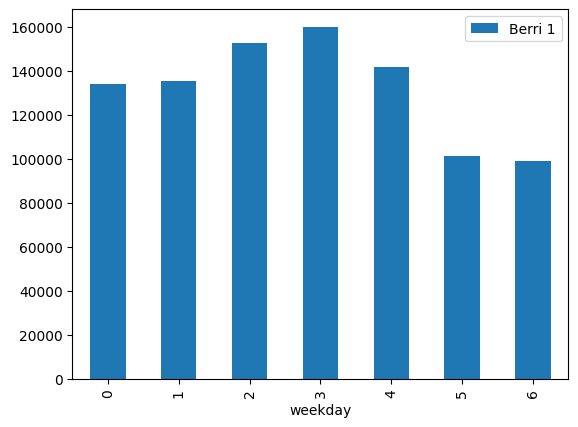

In [48]:
result_ptr = guest_client.code.get_bike_hist(bikes=asset)
real_result = result_ptr.get()
real_result.plot(kind="bar")

In [49]:
node.land()

Stopping pandas-test-domain-4
